Input files:
- digital orthophoto RGB (dof.tif)
- digital orthophoto IR (dofir.tif)

In [1]:
%run sql_magics.ipynb

In [2]:
%%sql
---------------clear the database for this exercise
DROP TABLE IF EXISTS dof CASCADE;
DROP TABLE IF EXISTS dofir CASCADE;
DROP TABLE IF EXISTS ndvi CASCADE;
DROP TABLE IF EXISTS ndvi2 CASCADE;

NOTICE:  table "ndvi2" does not exist, skipping
DROP TABLE


In [3]:
%%capture
#import of raster files
!raster2pgsql -s 3794 -I /opt/workshop/exercise_2/dof.tif -t 100x100 -Y -C dof | psql -h localhost -d giws -U user

4.19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
%%capture
!raster2pgsql -s 3794 -I /opt/workshop/exercise_2/dofir.tif -t 100x100 -Y -C dofir | psql -h localhost -d giws -U user

3.89 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### ST_AddBand
We are going to add band 1 from `dofir` as the 4th band of `dof`.

In [5]:
%%sql

-- we have to drop constraints in order to update dof table, because constraints are build for 3 band raster
SELECT DropRasterConstraints ('dof','rast');
 
UPDATE dof
SET
    rast = foo.rast
FROM 
(
    SELECT dof.rid, ST_AddBand(dof.rast,dofir.rast) rast from dof,dofir where dof.rid = dofir.rid
) foo

WHERE
    dof.rid = foo.rid;

SELECT AddRasterConstraints('dof'::name, 'rast'::name);

NOTICE:  Dropping SRID constraint
NOTICE:  Dropping scale-X constraint
NOTICE:  Dropping scale-Y constraint
NOTICE:  Dropping blocksize-X constraint
NOTICE:  Dropping blocksize-Y constraint
NOTICE:  Dropping alignment constraint
NOTICE:  The constraint "enforce_regular_blocking_rast" does not exist.  Skipping
NOTICE:  Dropping coverage tile constraint required for regular blocking
NOTICE:  The constraint "enforce_coverage_tile_rast" does not exist.  Skipping
NOTICE:  Dropping spatially unique constraint required for regular blocking
NOTICE:  Dropping number of bands constraint
NOTICE:  Dropping pixel type constraint
NOTICE:  Dropping nodata value constraint
NOTICE:  Dropping out-of-database constraint
NOTICE:  Dropping maximum extent constraint
NOTICE:  Adding SRID constraint
NOTICE:  Adding scale-X constraint
NOTICE:  Adding scale-Y constraint
NOTICE:  Adding blocksize-X constraint
NOTICE:  Adding blocksize-Y constraint
NOTICE:  Adding alignment constraint
NOTICE:  Adding number of ba

## NDVI

The formula for NDVI is well-known:

$\mathit{NDVI} = \frac{\mathit{NIR} - Red}{\mathit{NIR} + Red} $

### ST_MapAlgebra

- ST_MapAlgebra (callback function version) - Returns a one-band raster given one or more input rasters, band indexes and one user-specified callback function.
- ST_MapAlgebra (expression version) - Returns a one-band raster given one or two input rasters, band indexes and one or more user-specified SQL expressions.


In [6]:
%%sql

-----------------------------------> THIS TAKES about 1 minute to execute

-- NDVI expression version

SELECT
    dof.rid,ST_MapAlgebra(
    dof.rast, 1,
    dof.rast, 4,
    '([rast2.val] - [rast1.val]) / ([rast2.val] + [rast1.val])::float','32BF'
) rast
INTO ndvi FROM dof;

SELECT 2255
48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
%%sql
--------------------
----ndvi callback function
----HEADS UP: we are using \ before the $ sign because we are passing the function to database from jupyter
----and $ sign needs to be escaped. If we define this function directly in PostgreSQL client we must not escape
----the dolar sign.
--------------------
CREATE OR REPLACE FUNCTION ndvi_callback(value double precision[][][], pos integer[][], VARIADIC userargs text[])
	RETURNS double precision
	AS \$\$
	BEGIN
		RETURN (value [2][1][1] - value [1][1][1]) / (value [2][1][1] + value [1][1][1]);
	END;
	\$\$ LANGUAGE 'plpgsql' IMMUTABLE;

CREATE FUNCTION


In [8]:
%%sql

-----------------------------------> THIS TAKES about 1 minute to execute

-- NDVI callback function version

SELECT
    dof.rid,ST_MapAlgebra(
    dof.rast, ARRAY[1,4],
    'ndvi_callback(double precision[], integer[], text[])'::regprocedure,
    '32BF'::text
) rast
INTO ndvi2 FROM dof;

SELECT 2255
42.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


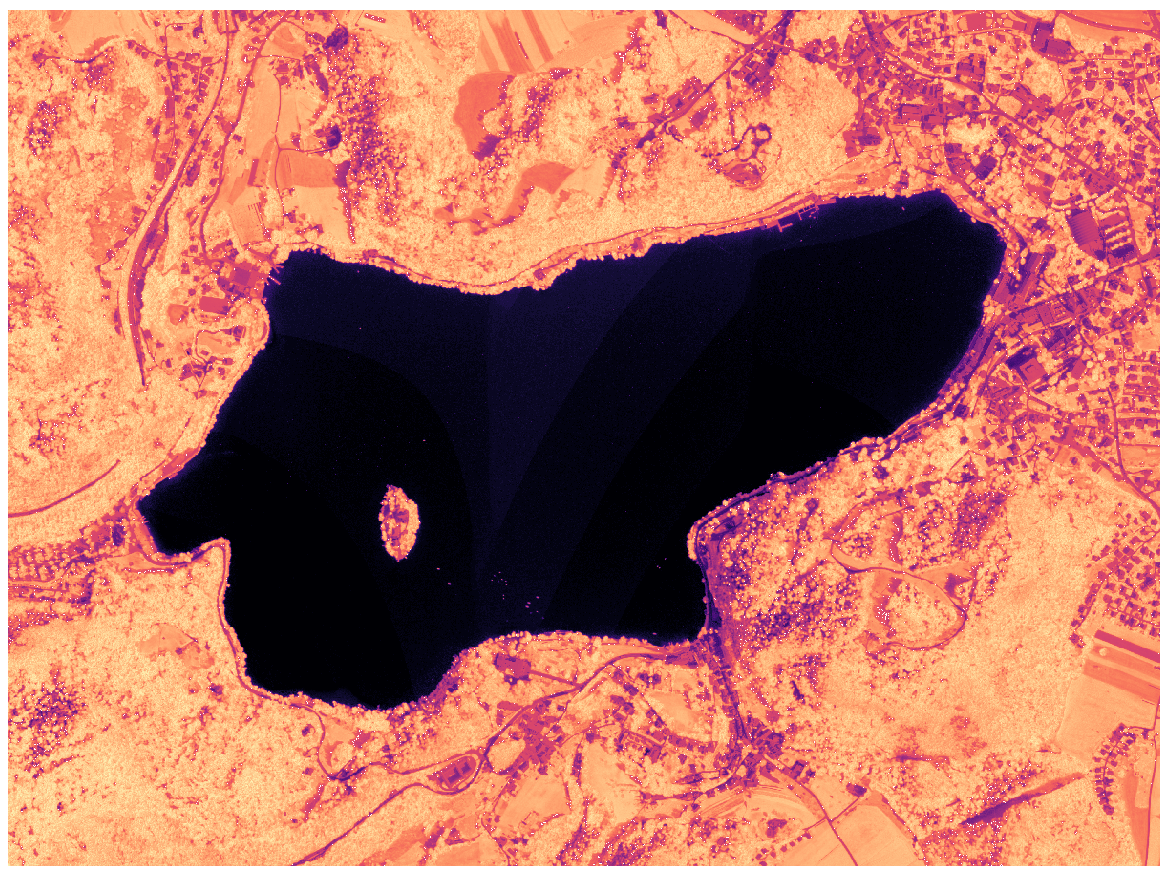
<center> NDVI image </center>

### ST_Quantile

In [9]:
%%sql
-------------we are going to reclassify ndvi on quantile values
SELECT (qua).* FROM
    (SELECT ST_Quantile(ST_Union(rast), ARRAY[0, 0.25, 0.5, 0.75, 1]) qua FROM ndvi) foo

 quantile |       value        
----------+--------------------
        0 |                 -1
     0.25 | -0.813953459262848
      0.5 |             0.1875
     0.75 |  0.352112680673599
        1 |  0.624309420585632
(5 rows)



### ST_Reclass

In [18]:
%%sql
DROP TABLE IF EXISTS ndvi_reclassified CASCADE;
CREATE TABLE ndvi_reclassified AS (
SELECT ST_Reclass(rast, 1, 
    '[-1--0.81]:1,
     (-0.81-0.19]:2,
      (0.19-0.35]:3,
      (0.62-1]:4', 
        '4BUI', 0) AS rast
    FROM  ndvi)

SELECT 2255


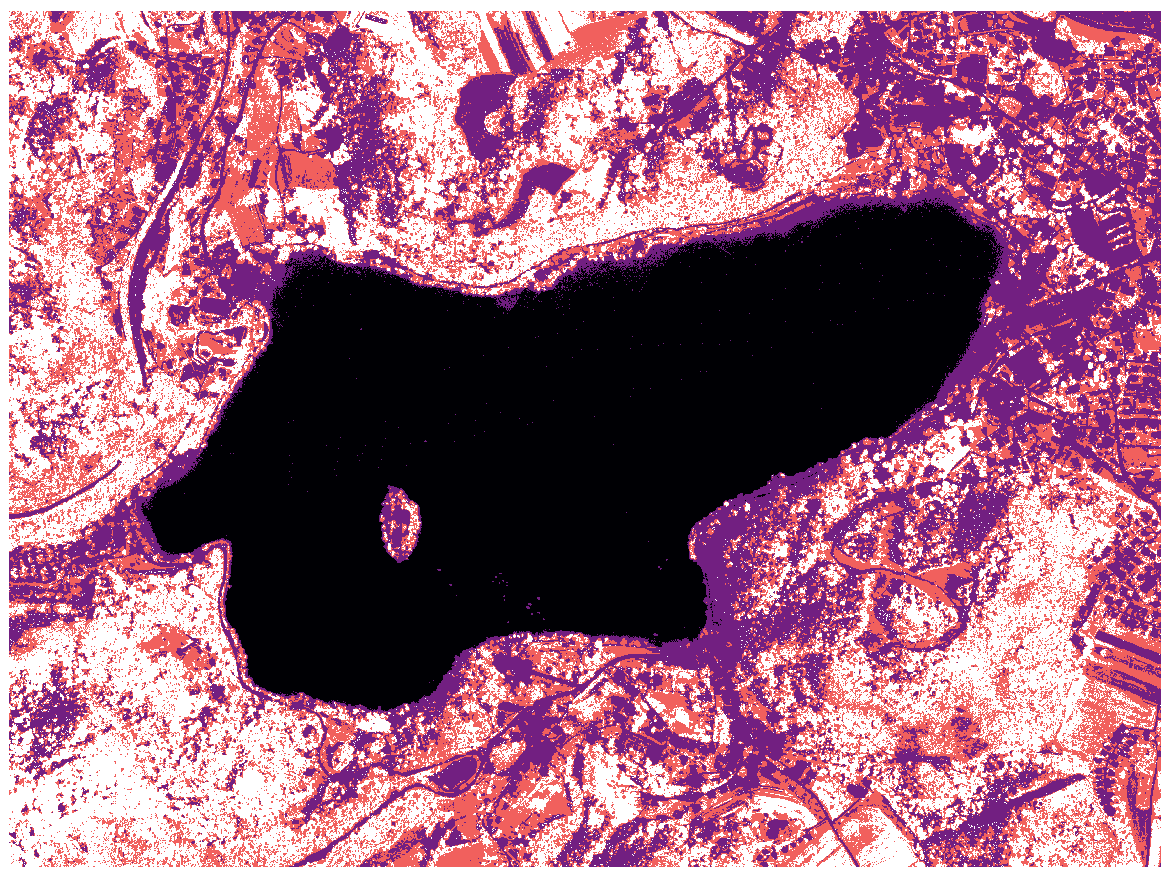
<center> Reclassified NDVI image</center>

https://gis.stackexchange.com/questions/222662/why-is-pgraster-much-slower

## Exercise: select pixels above the given value

For the exercise let's select all the pixels from the first band with the value above the mean value.

In [12]:
%%sql
------------
----mean value can be obtained from the result of the ST_SummaryStats function
------------
SELECT ST_SummaryStats(rast) from ndvi;

                                            st_summarystats                                             
--------------------------------------------------------------------------------------------------------
 (10000,3542.20052318275,0.354220052318275,0.0655276992159157,0.0681818202137947,0.529411792755127)
 (9997,3748.85260503786,0.374997759831735,0.0760605281517719,-0.0459770113229752,0.547169804573059)
 (10000,2468.85029622167,0.246885029622167,0.0767596070565619,0.0679012313485146,0.475935816764832)
 (10000,3614.89910234511,0.361489910234511,0.015733967692766,0.208791211247444,0.401515156030655)
 (10000,3697.02698329091,0.369702698329091,0.0128642683341298,0.306122452020645,0.459770113229752)
 (10000,3697.27453921735,0.369727453921735,0.0395467989735422,0.150943398475647,0.511961698532104)
 (9992,3255.92990585137,0.325853673523956,0.118075687988229,-0.243243247270584,0.551219522953033)
 (9962,2756.5576961448,0.276707257191808,0.156748126682222,-0.272727280855179,0.5530726313591)
 

`ST_SummaryStats` returns a composite data type. To get the field names we can run `ST_SummaryStats` like this:

In [13]:
%%sql
SELECT (stats).* FROM (
    SELECT ST_SummaryStats(rast) stats from ndvi
) a

 count |        sum        |         mean          |        stddev        |         min          |         max          
-------+-------------------+-----------------------+----------------------+----------------------+----------------------
 10000 |  3542.20052318275 |     0.354220052318275 |   0.0655276992159157 |   0.0681818202137947 |    0.529411792755127
  9997 |  3748.85260503786 |     0.374997759831735 |   0.0760605281517719 |  -0.0459770113229752 |    0.547169804573059
 10000 |  2468.85029622167 |     0.246885029622167 |   0.0767596070565619 |   0.0679012313485146 |    0.475935816764832
 10000 |  3614.89910234511 |     0.361489910234511 |    0.015733967692766 |    0.208791211247444 |    0.401515156030655
 10000 |  3697.02698329091 |     0.369702698329091 |   0.0128642683341298 |    0.306122452020645 |    0.459770113229752
 10000 |  3697.27453921735 |     0.369727453921735 |   0.0395467989735422 |    0.150943398475647 |    0.511961698532104
  9992 |  3255.92990585137 |     0.325

  9980 |  3453.93689958937 |     0.346085861682302 |    0.100643936203717 |   -0.139534890651703 |    0.578313231468201
  9998 |  3601.95085049421 |     0.360267138477116 |   0.0958978462114318 |  -0.0101010100916028 |    0.597883582115173
 10000 |  3475.36775941588 |     0.347536775941588 |    0.103113116078169 |  0.00662251655012369 |     0.58787876367569
 10000 |  3996.45938041806 |     0.399645938041806 |   0.0627394376891746 |   0.0786516889929771 |    0.600000023841858
  9993 |  3617.13355422998 |     0.361966732135493 |    0.113901161388758 |   -0.149606302380562 |    0.558011054992676
  9971 |  2846.62337976554 |     0.285490259729771 |    0.193396623678994 |   -0.818181812763214 |    0.565714299678802
  9996 | -6459.19491388975 |    -0.646177962574004 |    0.452466372157302 |                   -1 |    0.496932506561279
 10000 | -9423.34352147579 |    -0.942334352147579 |   0.0191853221273374 |                   -1 |   -0.842105269432068
 10000 | -9452.77981066704 |    -0.94527

We need the mean value of the whole raster (the upper result are statistics for the individual tiles):

In [14]:
%%sql
SELECT (stats).* FROM (
    SELECT ST_SummaryStats(ST_Union(rast)) stats from ndvi
) a

  count   |        sum        |        mean         |      stddev       | min |        max        
----------+-------------------+---------------------+-------------------+-----+-------------------
 21718616 | -1784425.89918953 | -0.0821611238575023 | 0.545980700252627 |  -1 | 0.624309420585632
(1 row)



In [22]:
%%sql

-----------------------------------> THIS TAKES about 1 minute to execute

DROP TABLE IF EXISTS ndvi_filtered CASCADE;
DROP TABLE IF EXISTS ndvi_filtered_retiled CASCADE;
CREATE TABLE ndvi_filtered AS (

SELECT rid, 
    ST_Intersection( 
        rast,
        ST_Reclass(rast, 1, '[-1--0.08):0,[0.08-1]:1', '2BUI', 0)
    ) rast from ndvi);

--for smoother operation in QGIS we retile the result
CREATE TABLE ndvi_filtered_retiled AS (
    SELECT (row_number() over ()) rid, ST_Tile(rast,1000,1000) rast from (SELECT ST_Union(rast) rast FROM ndvi_filtered) a);

SELECT AddRasterConstraints('ndvi_filtered_retiled'::name, 'rast'::name);

CREATE INDEX ndvi_filtered_retiled_st_convexhull_idx
  ON ndvi_filtered_retiled
  USING gist
  (ST_ConvexHull(rast));


NOTICE:  table "ndvi_filtered_retiled" does not exist, skipping
NOTICE:  Adding SRID constraint
NOTICE:  Adding scale-X constraint
NOTICE:  Adding scale-Y constraint
NOTICE:  Adding blocksize-X constraint
NOTICE:  Adding blocksize-Y constraint
NOTICE:  Adding alignment constraint
NOTICE:  Adding number of bands constraint
NOTICE:  Adding pixel type constraint
NOTICE:  Adding nodata value constraint
NOTICE:  Adding out-of-database constraint
NOTICE:  Adding maximum extent constraint
CREATE INDEX
59.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


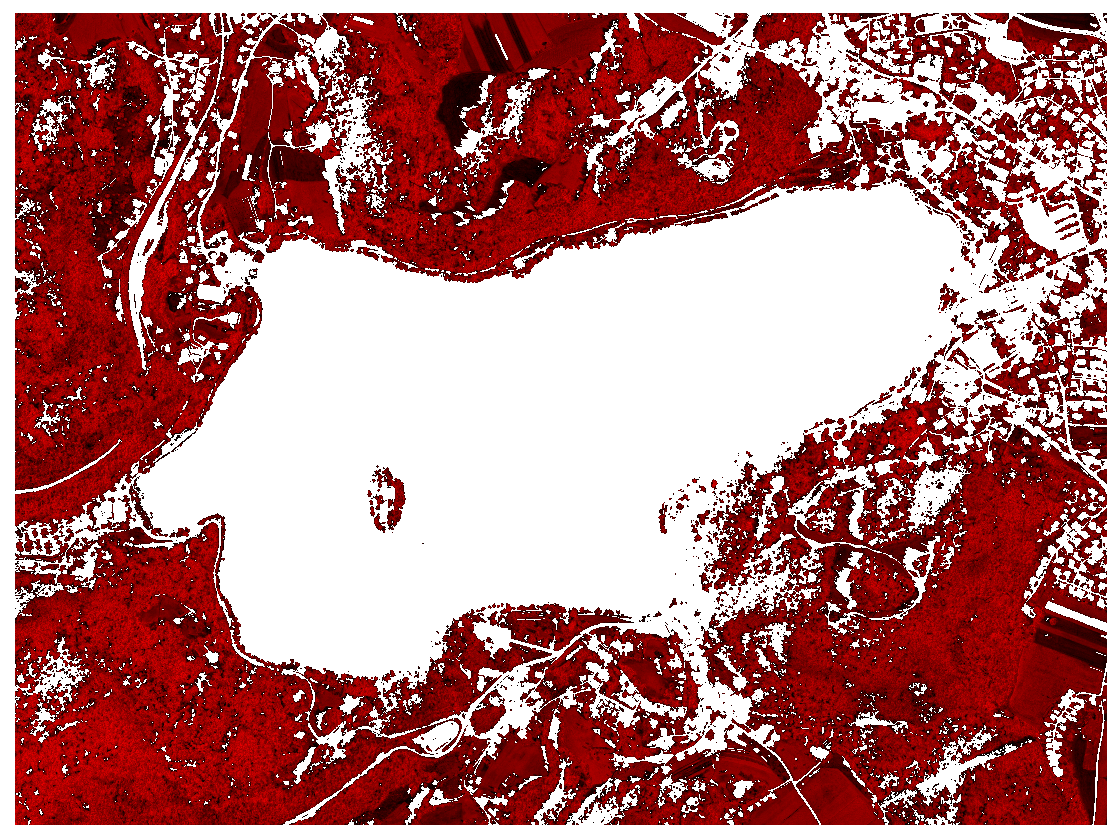